####  Convolutional Vision Transformer (CvT)

<!-- https://github.com/microsoft/CvT/blob/main/lib/models/cls_cvt.py -->

In [11]:
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.init import trunc_normal_, xavier_uniform_
from einops import rearrange
from einops.layers.torch import Rearrange
import math
from typing import Tuple

Helper Functions and Utility Classes

In [12]:
def to_2tuple(x):
    """Convert input to 2-tuple if it's not already."""
    if isinstance(x, (list, tuple)):
        return tuple(x)
    return (x, x)


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks)."""
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()  # binarize
        output = x.div(keep_prob) * random_tensor
        return output


class Mlp(nn.Module):
    """MLP as used in Vision Transformer, MLP-Mixer and related networks"""
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

Convolutional Attention and Transformer Block

In [13]:
class ConvAttention(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, qkv_bias=False, attn_drop=0., proj_drop=0.,
                 method='dw_bn', kernel_size=3, stride_kv=1, stride_q=1, padding_kv=1, padding_q=1,
                 with_cls_token=True, **kwargs):
        super().__init__()
        self.stride_kv = stride_kv
        self.stride_q = stride_q
        self.dim = dim_out
        self.num_heads = num_heads
        self.scale = dim_out ** -0.5
        self.with_cls_token = with_cls_token

        self.conv_proj_q = self._build_projection(
            dim_in, dim_out, kernel_size, padding_q, stride_q, 'linear' if method == 'avg' else method
        )
        self.conv_proj_k = self._build_projection(
            dim_in, dim_out, kernel_size, padding_kv, stride_kv, method
        )
        self.conv_proj_v = self._build_projection(
            dim_in, dim_out, kernel_size, padding_kv, stride_kv, method
        )

        self.proj_q = nn.Linear(dim_in, dim_out, bias=qkv_bias)
        self.proj_k = nn.Linear(dim_in, dim_out, bias=qkv_bias)
        self.proj_v = nn.Linear(dim_in, dim_out, bias=qkv_bias)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim_out, dim_out)
        self.proj_drop = nn.Dropout(proj_drop)

    def _build_projection(self, dim_in, dim_out, kernel_size, padding, stride, method):
        if method == 'dw_bn':
            proj = nn.Sequential(OrderedDict([
                ('conv', nn.Conv2d(
                    dim_in, dim_in, kernel_size=kernel_size, padding=padding,
                    stride=stride, bias=False, groups=dim_in
                )),
                ('bn', nn.BatchNorm2d(dim_in)),
                ('rearrange', Rearrange('b c h w -> b (h w) c')),
            ]))
        elif method == 'avg':
            proj = nn.Sequential(OrderedDict([
                ('avg', nn.AvgPool2d(
                    kernel_size=kernel_size, padding=padding, stride=stride, ceil_mode=True
                )),
                ('rearrange', Rearrange('b c h w -> b (h w) c')),
            ]))
        elif method == 'linear':
            proj = None
        else:
            raise ValueError('Unknown method ({})'.format(method))
        return proj

    def forward_conv(self, x, h, w):
        if self.conv_proj_q is not None:
            q = self.conv_proj_q(x)
        else:
            q = rearrange(x, 'b c h w -> b (h w) c')

        if self.conv_proj_k is not None:
            k = self.conv_proj_k(x)
        else:
            k = rearrange(x, 'b c h w -> b (h w) c')

        if self.conv_proj_v is not None:
            v = self.conv_proj_v(x)
        else:
            v = rearrange(x, 'b c h w -> b (h w) c')

        return q, k, v

    def forward(self, x, h, w):
        if self.with_cls_token:
            cls_token, x = torch.split(x, [1, h*w], 1)

        # conv proj
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        q, k, v = self.forward_conv(x, h, w)

        if self.with_cls_token:
            q = torch.cat((self.proj_q(cls_token), q), dim=1)
            k = torch.cat((self.proj_k(cls_token), k), dim=1)
            v = torch.cat((self.proj_v(cls_token), v), dim=1)

        # apply linear projection
        q = self.proj_q(q)
        k = self.proj_k(k)
        v = self.proj_v(v)

        # reshape for multi-head attention
        B, N, C = q.shape
        q = q.reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        k = k.reshape(B, -1, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        v = v.reshape(B, -1, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        # attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class Block(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, **kwargs):
        super().__init__()

        self.with_cls_token = kwargs['with_cls_token']

        self.norm1 = norm_layer(dim_in)
        self.attn = ConvAttention(
            dim_in, dim_out, num_heads, qkv_bias, attn_drop, drop, **kwargs
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim_out)

        dim_mlp_hidden = int(dim_out * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim_out,
            hidden_features=dim_mlp_hidden,
            act_layer=act_layer,
            drop=drop
        )

    def forward(self, x, h, w):
        res = x
        x = self.norm1(x)
        attn = self.attn(x, h, w)
        x = res + self.drop_path(attn)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

Implementation of Convolutional Projection

* If the method is **dw_bn** (depthwise separable with batch normalization), it creates a Sequential block consisting of a depthwise separable convolutional layer followed by batch normalization and rearranges the dimensions.

* If the method is **avg** (average pooling), it creates a Sequential block with an average pooling layer followed by rearranging the dimensions.

* If the method is **linear**, it returns None, indicating that no projection is applied.

Implementation of Convolutional Token Embedding

In [14]:
class ConvEmbed(nn.Module):
    def __init__(
        self, patch_size=7, in_chans=3, embed_dim=64, stride=4, padding=2, norm_layer=None
    ):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        self.patch_size = patch_size

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=stride, padding=padding
        )
        self.norm = norm_layer(embed_dim) if norm_layer else None

    def forward(self, x):
        x = self.proj(x)

        B, C, H, W = x.shape
        x = rearrange(x, "b c h w -> b (h w) c")
        if self.norm:
            x = self.norm(x)
        x = rearrange(x, "b (h w) c -> b c h w", h=H, w=W)

        return x

Vision Transformer Block

In [15]:
class VisionTransformer(nn.Module):
    """Vision Transformer with support for patch or hybrid CNN input stage"""

    def __init__(
        self,
        patch_size=16,
        patch_stride=16,
        patch_padding=0,
        in_chans=3,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=False,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
        init="trunc_norm",
        **kwargs,
    ):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim

        self.patch_embed = ConvEmbed(
            patch_size=patch_size,
            in_chans=in_chans,
            stride=patch_stride,
            padding=patch_padding,
            embed_dim=embed_dim,
            norm_layer=norm_layer,
        )

        with_cls_token = kwargs.get("with_cls_token", True)
        if with_cls_token:
            self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        else:
            self.cls_token = None

        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [
            x.item() for x in torch.linspace(0, drop_path_rate, depth)
        ]  # stochastic depth decay rule

        blocks = []
        for j in range(depth):
            # transformer blocks
            blocks.append(
                Block(
                    dim_in=embed_dim,
                    dim_out=embed_dim,
                    num_heads=num_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    drop=drop_rate,
                    attn_drop=attn_drop_rate,
                    drop_path=dpr[j],
                    act_layer=act_layer,
                    norm_layer=norm_layer,
                    **kwargs,
                )
            )
        self.blocks = nn.ModuleList(blocks)

        if self.cls_token is not None:
            trunc_normal_(self.cls_token, std=0.02)

        if init == "xavier":
            self.apply(self._init_weights_xavier)
        else:
            self.apply(self._init_weights_trunc_normal)

    def _init_weights_trunc_normal(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.LayerNorm, nn.BatchNorm2d)):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def _init_weights_xavier(self, m):
        if isinstance(m, nn.Linear):
            xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.LayerNorm, nn.BatchNorm2d)):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        x = self.patch_embed(x)
        B, C, H, W = x.size()

        x = rearrange(x, "b c h w -> b (h w) c")

        cls_tokens = None
        if self.cls_token is not None:
            cls_tokens = self.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)

        x = self.pos_drop(x)

        for i, blk in enumerate(self.blocks):
            x = blk(x, H, W)

        if self.cls_token is not None:
            cls_tokens, x = torch.split(x, [1, H * W], 1)
        x = rearrange(x, "b (h w) c -> b c h w", h=H, w=W)

        return x, cls_tokens

Convolutional Vision Transformer Block (Hierarchy of Transformers)

In [16]:
class ConvolutionalVisionTransformer(nn.Module):
    def __init__(
        self,
        in_chans=3,
        num_classes=1000,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
        init="trunc_norm",
        spec=None,
    ):
        super().__init__()
        self.num_classes = num_classes

        self.num_stages = spec["NUM_STAGES"]
        for i in range(self.num_stages):
            kwargs = {
                "patch_size": spec["PATCH_SIZE"][i],
                "patch_stride": spec["PATCH_STRIDE"][i],
                "patch_padding": spec["PATCH_PADDING"][i],
                "embed_dim": spec["DIM_EMBED"][i],
                "depth": spec["DEPTH"][i],
                "num_heads": spec["NUM_HEADS"][i],
                "mlp_ratio": spec["MLP_RATIO"][i],
                "qkv_bias": spec["QKV_BIAS"][i],
                "drop_rate": spec["DROP_RATE"][i],
                "attn_drop_rate": spec["ATTN_DROP_RATE"][i],
                "drop_path_rate": spec["DROP_PATH_RATE"][i],
                "with_cls_token": spec["CLS_TOKEN"][i],
                "method": spec["QKV_PROJ_METHOD"][i],
                "kernel_size": spec["KERNEL_QKV"][i],
                "padding_q": spec["PADDING_Q"][i],
                "padding_kv": spec["PADDING_KV"][i],
                "stride_kv": spec["STRIDE_KV"][i],
                "stride_q": spec["STRIDE_Q"][i],
            }

            stage = VisionTransformer(
                in_chans=in_chans,
                init=init,
                act_layer=act_layer,
                norm_layer=norm_layer,
                **kwargs,
            )
            setattr(self, f"stage{i}", stage)

            in_chans = spec["DIM_EMBED"][i]

        dim_embed = spec["DIM_EMBED"][-1]
        self.norm = norm_layer(dim_embed)
        self.cls_token = spec["CLS_TOKEN"][-1]

        # Classifier head
        self.head = (
            nn.Linear(dim_embed, num_classes) if num_classes > 0 else nn.Identity()
        )
        trunc_normal_(self.head.weight, std=0.02)

    def forward_features(self, x):
        for i in range(self.num_stages):
            x, cls_tokens = getattr(self, f"stage{i}")(x)

        if self.cls_token:
            x = self.norm(cls_tokens)
            x = torch.squeeze(x)
        else:
            x = rearrange(x, "b c h w -> b (h w) c")
            x = self.norm(x)
            x = torch.mean(x, dim=1)

        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)

        return x

Configuration and Example Usage

In [17]:
# Example configuration for CvT-13
cvt_13_spec = {
    'NUM_STAGES': 3,
    'PATCH_SIZE': [7, 3, 3],
    'PATCH_STRIDE': [4, 2, 2],
    'PATCH_PADDING': [2, 1, 1],
    'DIM_EMBED': [64, 192, 384],
    'NUM_HEADS': [1, 3, 6],
    'DEPTH': [1, 2, 10],
    'MLP_RATIO': [4.0, 4.0, 4.0],
    'ATTN_DROP_RATE': [0.0, 0.0, 0.0],
    'DROP_RATE': [0.0, 0.0, 0.0],
    'DROP_PATH_RATE': [0.0, 0.0, 0.1],
    'QKV_BIAS': [True, True, True],
    'CLS_TOKEN': [False, False, True],
    'QKV_PROJ_METHOD': ['dw_bn', 'dw_bn', 'dw_bn'],
    'KERNEL_QKV': [3, 3, 3],
    'PADDING_KV': [1, 1, 1],
    'STRIDE_KV': [2, 2, 2],
    'PADDING_Q': [1, 1, 1],
    'STRIDE_Q': [1, 1, 1],
}

# Create CvT model
model = ConvolutionalVisionTransformer(
    in_chans=3,
    num_classes=1000,
    act_layer=nn.GELU,
    norm_layer=nn.LayerNorm,
    init='trunc_norm',
    spec=cvt_13_spec
)

print(f'Model created with {sum(p.numel() for p in model.parameters())} parameters')
print(f'Model: {model.__class__.__name__}')

Model created with 19997480 parameters
Model: ConvolutionalVisionTransformer


In [18]:
# Test forward pass
batch_size = 2
input_tensor = torch.randn(batch_size, 3, 224, 224)

print(f'Input shape: {input_tensor.shape}')

# Forward pass
with torch.no_grad():
    output = model(input_tensor)
    print(f'Output shape: {output.shape}')
    print(f'Output range: [{output.min().item():.4f}, {output.max().item():.4f}]')

print('\nForward pass successful!')

Input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 1000])
Output range: [-1.2889, 1.4625]

Forward pass successful!


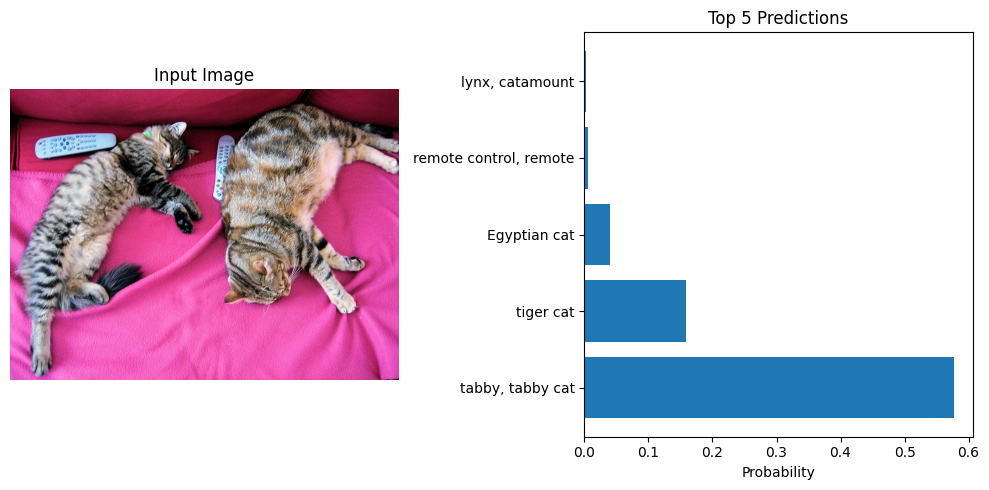

Top prediction: tabby, tabby cat (57.76% confidence)


In [22]:
from transformers import AutoFeatureExtractor, CvtForImageClassification
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Input Image")
plt.axis('off')

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/cvt-13")
model = CvtForImageClassification.from_pretrained("microsoft/cvt-13")

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
# predicted_class_idx = logits.argmax(-1).item()
# print("Predicted class:", model.config.id2label[predicted_class_idx])

# Get top 5 predictions
top_k = 5
probs = torch.nn.functional.softmax(logits, dim=-1)
top_probs, top_indices = torch.topk(probs, top_k)

# Convert to lists
top_probs = top_probs.squeeze().tolist()
top_indices = top_indices.squeeze().tolist()

# Get class names
class_names = [model.config.id2label[idx] for idx in top_indices]

# Display top predictions
plt.subplot(1, 2, 2)
y_pos = np.arange(len(class_names))
plt.barh(y_pos, top_probs, align='center')
plt.yticks(y_pos, class_names)
plt.xlabel('Probability')
plt.title('Top 5 Predictions')

plt.tight_layout()
plt.show()

# Print the top prediction
predicted_label = logits.argmax(-1).item()
print(f"Top prediction: {model.config.id2label[predicted_label]} ({top_probs[0]:.2%} confidence)")

Looks like CvT is more thoughtful than simple ResNets...